In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
import operator
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix


import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import settings

import Stemmer
import statsmodels.api as sm

/Users/owentemple/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def read_data():
    df = pd.read_excel(os.path.join('..',settings.PROCESSED_DIR, "all_with_liwc_segmented.xls"), encoding="ISO-8859-1")
    return df

In [3]:
df = read_data()

In [4]:
df['norm_unconvincing'].describe()

count    2406.000000
mean       43.253156
std        80.961344
min         0.000000
25%         9.317012
50%        20.728141
75%        49.766783
max      2112.507895
Name: norm_unconvincing, dtype: float64

In [5]:
views_median = df['norm_unconvincing'].median()
views_upper_quantile = df['norm_unconvincing'].quantile(.75)

In [6]:
df['unconvincing_label'] = np.where(df['norm_unconvincing'] >= views_median, 1, 0)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
stemmer = SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [8]:
count_vect = StemmedCountVectorizer(analyzer="word", stop_words='english', min_df=2)
X_train_counts = count_vect.fit_transform(df['transcript'])
X_train_counts.shape

(2406, 20462)

In [9]:
sorted(count_vect.vocabulary_.items(), key=operator.itemgetter(1), reverse=True)

[('î¾', 20461),
 ('éte', 20460),
 ('èé', 20459),
 ('èâthank', 20458),
 ('èâso', 20457),
 ('èâ', 20456),
 ('ève', 20455),
 ('èt', 20454),
 ('ès', 20453),
 ('ère', 20452),
 ('èm', 20451),
 ('èll', 20450),
 ('èd', 20449),
 ('ås', 20448),
 ('åres', 20447),
 ('åre', 20446),
 ('åme', 20445),
 ('àvet', 20444),
 ('àveli', 20443),
 ('àve', 20442),
 ('zx81', 20441),
 ('zurich', 20440),
 ('zulu', 20439),
 ('zuckerman', 20438),
 ('zuckerberg', 20437),
 ('zuccotti', 20436),
 ('zopa', 20435),
 ('zooplankton', 20434),
 ('zoop', 20433),
 ('zoonot', 20432),
 ('zoom', 20431),
 ('zoolog', 20430),
 ('zoo', 20429),
 ('zone', 20428),
 ('zombi', 20427),
 ('zoe', 20426),
 ('zodiac', 20425),
 ('zipper', 20424),
 ('ziploc', 20423),
 ('ziplin', 20422),
 ('zipcar', 20421),
 ('zip', 20420),
 ('zine', 20419),
 ('zinc', 20418),
 ('zimbardo', 20417),
 ('zimbabwean', 20416),
 ('zimbabw', 20415),
 ('zillion', 20414),
 ('zilch', 20413),
 ('zika', 20412),
 ('zigzag', 20411),
 ('zig', 20410),
 ('zheng', 20409),
 ('zf', 20

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2406, 20462)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, df['unconvincing_label'])

In [13]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)

In [14]:
predicted = clf.predict(X_test)
np.mean(predicted == y_test)

0.66943521594684385

In [15]:
clf.score(X_test, y_test)

0.66943521594684385

Classification accuracy is 67%

Null accuracy: accuracy that could be achieved by always predicting the most frequent class


In [16]:
# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
max(y_test.mean(), 1 - y_test.mean())

0.5016611295681064

This means that a dumb model that always predicts 0 would be right 50% of the time

This shows how classification accuracy is fairly good as 17% higher than a dumb model
It's a good way to know the minimum we should achieve with our models

In [17]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

standard_confusion_matrix(y_test, predicted)

array([[215, 114],
       [ 85, 188]])

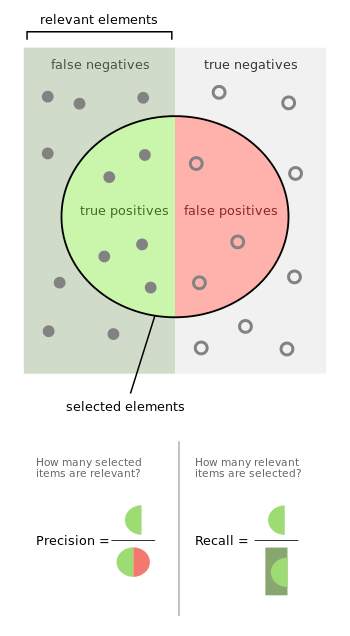

In [18]:
recall = recall_score(y_test, predicted)
recall

0.71666666666666667

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [19]:
precision = precision_score(y_test, predicted)
precision

0.65349544072948329

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

In [20]:
F1 = 2 * (precision * recall) / (precision + recall)
F1

0.68362480127186009

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

In [22]:
def show_most_informative_features(vectorizer, clf, n=100):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    top_words = []
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        top_words.append((coef_2, fn_2))
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
    top_words_df = pd.DataFrame(top_words, columns=['coefficient', 'word'])
    top_words_df.to_csv('top-words-unconvincing.csv')
    return top_words_df

In [23]:
top_words_df = show_most_informative_features(count_vect,clf)

	-10.3816	0001           		-6.5559	peopl          
	-10.3816	02             		-6.6640	like           
	-10.3816	040            		-6.7969	think          
	-10.3816	07             		-6.8095	thing          
	-10.3816	104            		-6.8358	just           
	-10.3816	109            		-6.9113	go             
	-10.3816	118            		-6.9245	know           
	-10.3816	121            		-6.9960	year           
	-10.3816	125th          		-7.0291	realli         
	-10.3816	1298           		-7.0326	world          
	-10.3816	133            		-7.0535	time           
	-10.3816	143            		-7.0905	look           
	-10.3816	1500           		-7.0955	want           
	-10.3816	152            		-7.1279	make           
	-10.3816	161            		-7.1558	way            
	-10.3816	168            		-7.1581	ve             
	-10.3816	1700           		-7.1804	say            
	-10.3816	172            		-7.1997	don            
	-10.3816	1771           		-7.2051	work           
	-10.3816	1788           		-7.2

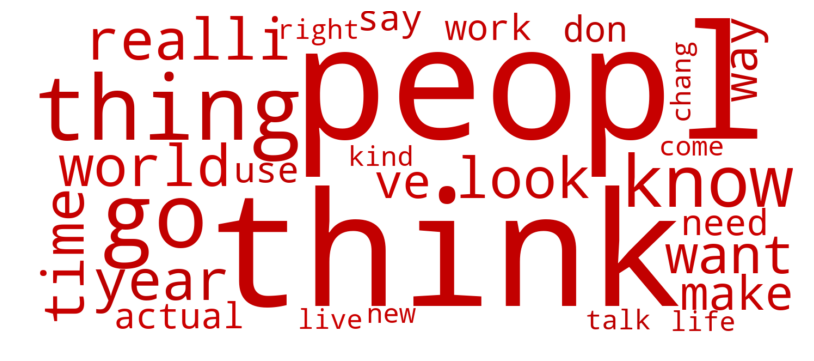

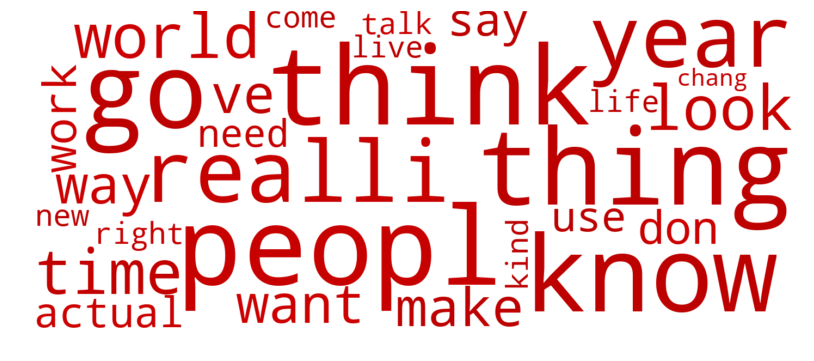

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
# Read the whole text.
text = top_words_df['word'].iloc[0:30].str.cat(sep=', ')

# Generate a word cloud image

wordcloud = WordCloud(width=1400, height=600, background_color='white').generate(text)

#change the value in return to set the single color need, in hsl format.
def red_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%%, %d%%)" % np.random.randint(37,41))

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(14,6))
wordcloud.recolor(color_func = red_color_func)
plt.imshow(wordcloud, interpolation='bilinear')
#change the color setting
plt.axis("off")
plt.savefig('Most Informative Features - Unconvincing')

# lower max_font_size
wordcloud = WordCloud(width=1400, height=600,background_color='white', max_font_size=200).generate(text)
plt.figure(figsize=(14,6))
wordcloud.recolor(color_func = red_color_func)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
unconvincing_df = pd.read_csv('top-words-unconvincing.csv')
persuasive_df = pd.read_csv('top-words-persuasive.csv')
unconvincing_set = set(unconvincing_df['word'].iloc[0:100])
persuasive_set = set(persuasive_df['word'].iloc[0:100])

unconvincing_unique = unconvincing_set.difference(persuasive_set)
persuasive_unique = persuasive_set.difference(unconvincing_set)

In [27]:
unconvincing_unique       

{'000',
 'book',
 'car',
 'comput',
 'doe',
 'energi',
 'global',
 'interest',
 'million',
 'sort',
 'space'}

In [28]:
persuasive_unique

{'busi',
 'communiti',
 'didn',
 'dollar',
 'educ',
 'end',
 'experi',
 'food',
 'men',
 'money',
 'turn'}

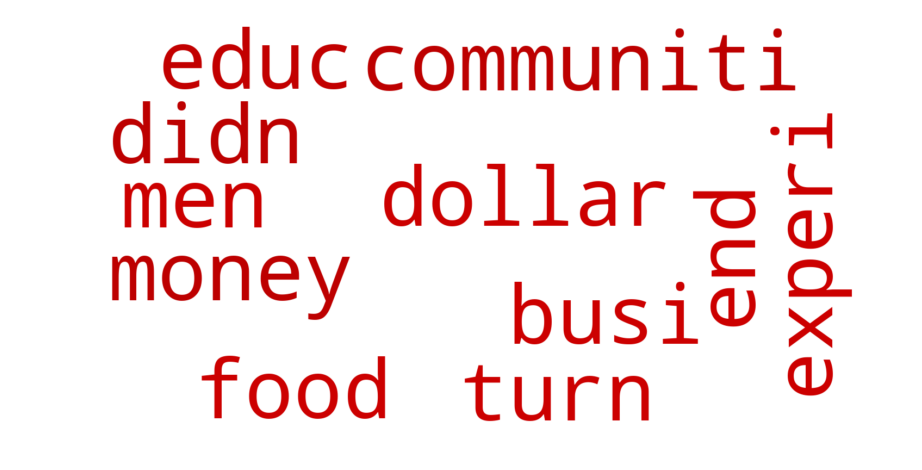

In [32]:
# Read the whole text.
text = ' '.join(persuasive_unique)

# Generate a word cloud image

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(text)

#change the value in return to set the single color need, in hsl format.
def red_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%%, %d%%)" % np.random.randint(37,41))

# lower max_font_size
wordcloud = WordCloud(width=1600, height=800,background_color='white', max_font_size=150).generate(text)
plt.figure(figsize=(16,8))
wordcloud.recolor(color_func = red_color_func)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('Persuasive Uniques Versus Unconvincing in Top 100')
plt.show()

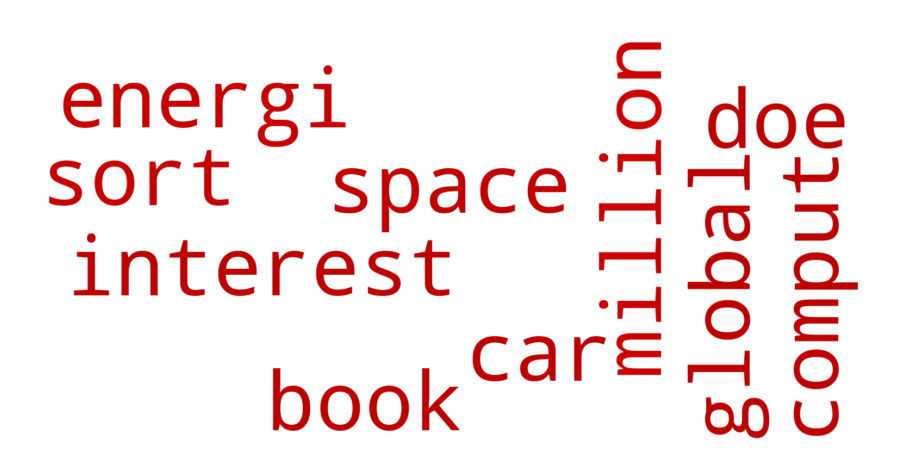

In [33]:
# Read the whole text.
text = ' '.join(unconvincing_unique)

# Generate a word cloud image

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(text)

#change the value in return to set the single color need, in hsl format.
def red_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%%, %d%%)" % np.random.randint(37,41))

# lower max_font_size
wordcloud = WordCloud(width=1600, height=800,background_color='white', max_font_size=150).generate(text)
plt.figure(figsize=(16,8))
wordcloud.recolor(color_func = red_color_func)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('Unconvincing Unique Versus Persuasive in Top 100')
plt.show()